Walk, Run or Jump
=====
I'm aware that images are not the best to quantify these actions. A video or motion tracking data would be preferable. But, i'm just starting out and wanted to do test boundaries. 

The error rate gets pretty low (1.6%), nevertheless i found that it still has a lot of problems predicting images i throw at it. It may rely on some image tendencies (walking often has wider landspace pictures).

In [1]:
from fastai.vision import *

Download images
===
Since we cant modify download_images because it calls a private member function. 
I merge all of my csv files into one big one and then throw it at download_images. 
I get a list of urls with google images as taught in [lesson 2](https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson2-download.ipynb).

In [2]:
def download_multiple(files,folder,path):
    dest = path/folder
    dest.mkdir(parents=True, exist_ok=True)
    urls = []
    outfile_name = Path(path , folder + ".csv")
    with open(outfile_name, 'w') as outfile:
        for file_name in files:
          file_name = path/file_name
          with open(file_name) as infile:
            outfile.write(infile.read())
        
    download_images(outfile_name, dest)

In [3]:
path = Path('data/action')

In [25]:
jumping_files = ['animal_jumping.csv','man_jumping_stock.csv','woman_jumping_stock.csv']
download_multiple(jumping_files,'jumping',path)

In [26]:
walking_files = ['walking_sideview.csv','walking_stock.csv']
download_multiple(walking_files,'walking',path)

In [27]:
running_files = ['running_sideview.csv']
download_multiple(running_files,'running',path)

In [16]:
classes = ['jumping','walking','running']

In [ ]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=1000)

jumping


Preprocessing
====
I do a first cnn run to just find out the biggest losses. I then use the jupyter widget to exclude unclear images and create a 'cleaned.csv'. I then begin training completely anew.

In [6]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [7]:
data.classes

['jumping', 'running', 'walking']

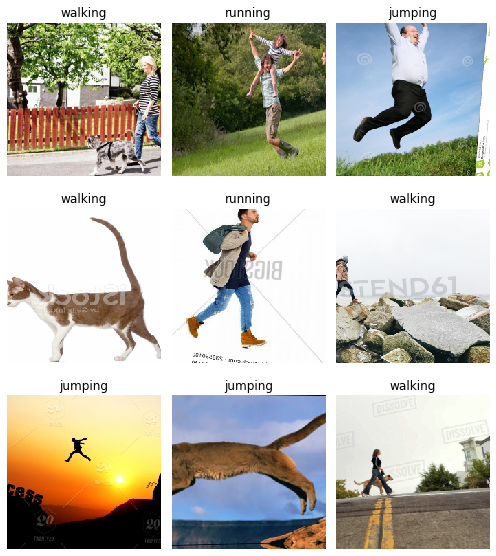

In [9]:
data.show_batch(rows=3, figsize=(7,8))

In [9]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [ ]:
learn.fit_one_cycle(8)

In [ ]:
learn.save('stage-1')

In [10]:
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (1893 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
jumping,jumping,jumping,jumping,jumping
Path: data\action;

Valid: LabelList (473 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
running,walking,jumping,walking,jumping
Path: data\action;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [13]:
learn.unfreeze()
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


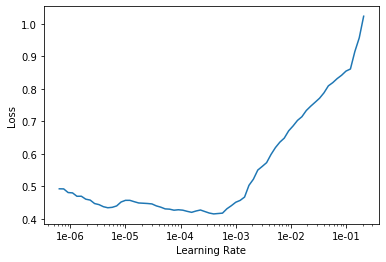

In [14]:
learn.recorder.plot()

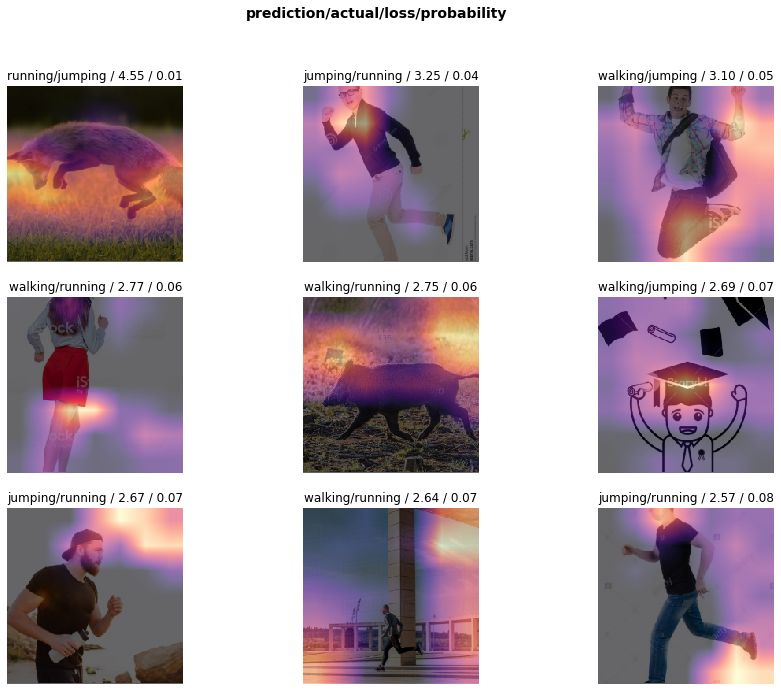

In [11]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

interp.plot_top_losses(9, figsize=(15,11))

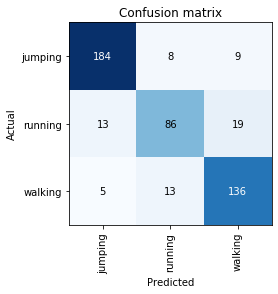

In [16]:
interp.plot_confusion_matrix()

Now preperation for cleaning up the data myself through widgets.

In [1]:
from fastai.widgets import *

In [ ]:
db = (ImageList.from_folder(path)
                   .split_none()
                   .label_from_folder()
                   .transform(get_transforms(), size=224)
                   .databunch()
     )

In [16]:
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)

learn_cln.load('stage-1');

In [17]:
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)

In [ ]:
ImageCleaner(ds, idxs, path)

In [3]:
data = ImageDataBunch.from_csv(path, folder=".", valid_pct=0.2, csv_labels='cleaned.csv',
ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [4]:
learn_cln = cnn_learner(data, models.resnet34, metrics=error_rate)

learn_cln.load('stage-1');

In [5]:
learn_cln.fit_one_cycle(2)

In [6]:
learn_cln.unfreeze()

In [7]:
learn_cln.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


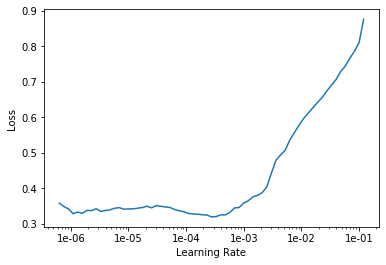

In [9]:
learn_cln.recorder.plot()

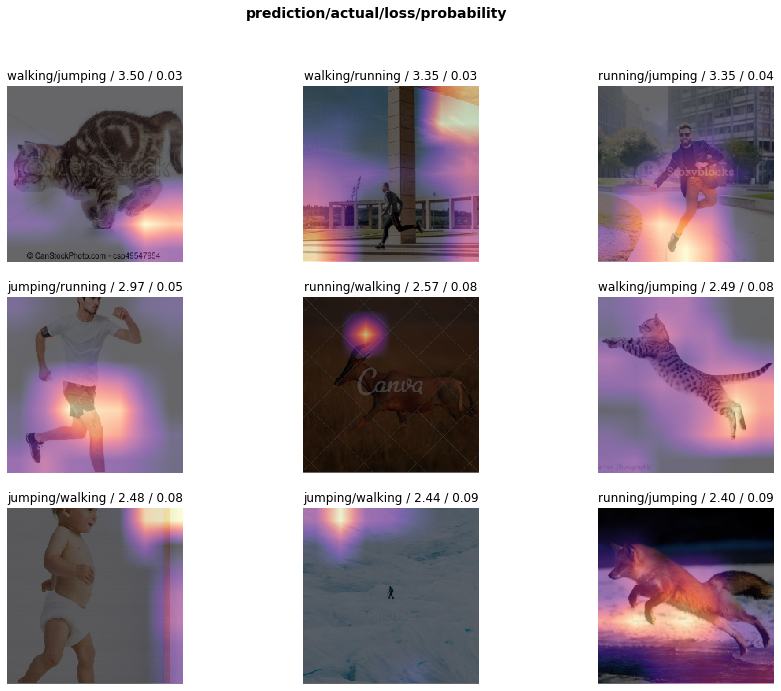

In [10]:
interp = ClassificationInterpretation.from_learner(learn_cln)

losses,idxs = interp.top_losses()

interp.plot_top_losses(9, figsize=(15,11))

Train anew 
====
Cleaned out the worst images. So we start anew with training.

In [4]:
data = ImageDataBunch.from_csv(path, folder=".", valid_pct=0.2, csv_labels='cleaned.csv',
ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)
learn_new = cnn_learner(data, models.resnet34, metrics=error_rate)

In [4]:
learn_new.fit_one_cycle(5)

In [6]:
learn_new.save('retrain');

In [7]:
learn_new.unfreeze()
learn_new.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


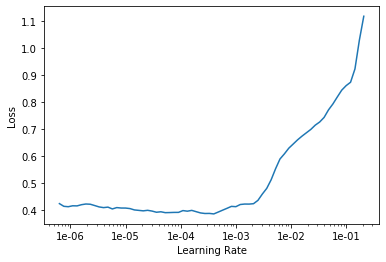

In [9]:
learn_new.recorder.plot()

One big jump from 0.2 error_rate to 0.14.

In [10]:
learn_new.load('retrain');
learn_new.fit_one_cycle(5)

In [11]:
learn_new.save('retrain-2');

In [22]:
learn_new.load('retrain-2');

In [23]:
learn_new.unfreeze()

In [ ]:
learn_new.lr_find()

In [ ]:
learn_new.recorder.plot()

In [24]:
learn_new.fit_one_cycle(4,max_lr=slice(4e-5,5e-4))

In [25]:
learn_new.save('retrain-3');

In [26]:
learn_new.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


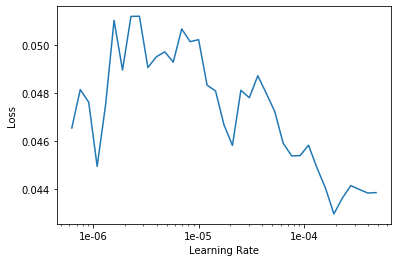

In [27]:
learn_new.recorder.plot()

In [6]:
learn_new.load('retrain-3');

Another big jump from 0.12 to 0.04 error_rate due to learning rate configuration.

In [7]:
learn_new.fit_one_cycle(4,max_lr=slice(6e-4,9.2e-3))

In [8]:
learn_new.save('retrain-4');

In [9]:
learn_new.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


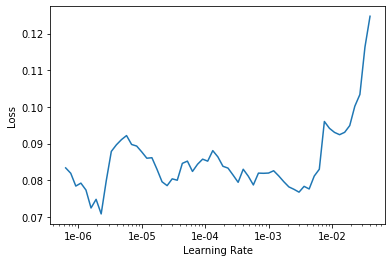

In [10]:
learn_new.recorder.plot()

In [11]:
learn_new.fit_one_cycle(1,max_lr=slice(4e-5,9e-4))

In [12]:
learn_new.save('retrain-5');

In [13]:
learn_new.fit_one_cycle(1,max_lr=slice(4e-5,9e-4))

In [15]:
learn_new.save('retrain-6');

In [12]:
learn_new.load('retrain-6');

In [6]:
learn_new.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


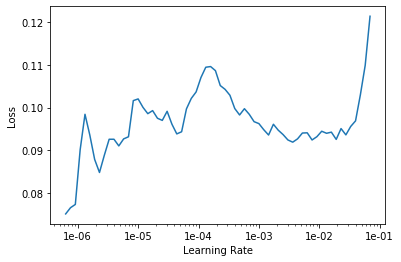

In [7]:
learn_new.recorder.plot()

Last big jump from 0.037 to 0.016 error_rate.

In [13]:
learn_new.fit_one_cycle(1,max_lr=slice(1e-5,5e-4))

In [15]:
learn_new.save('retrain-7');

In [18]:
learn_new.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


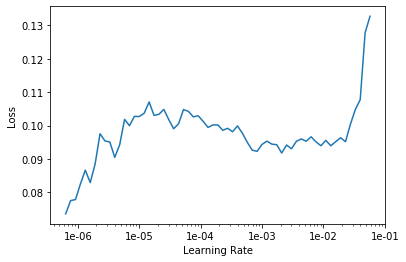

In [19]:
learn_new.recorder.plot()

In [21]:
learn_new.load('retrain-7');

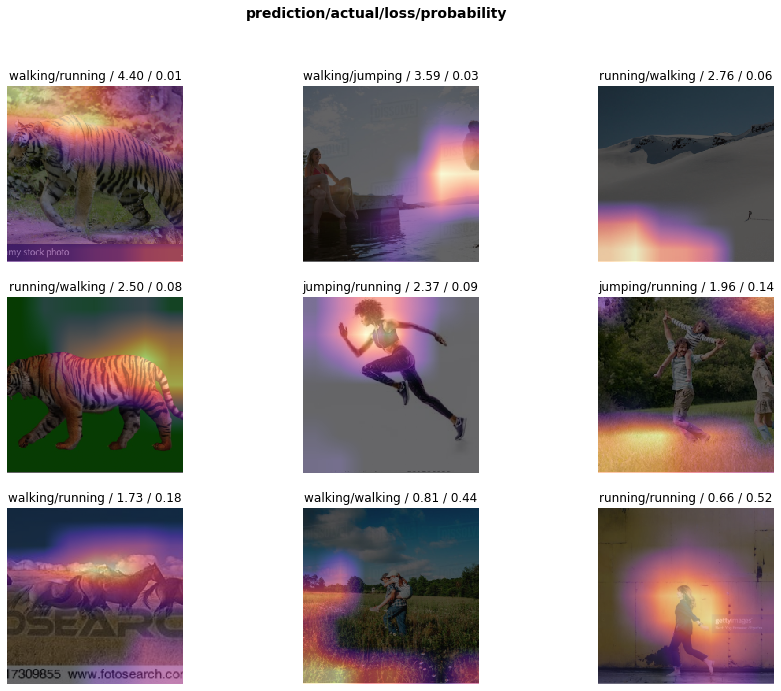

In [22]:
interp = ClassificationInterpretation.from_learner(learn_new)

losses,idxs = interp.top_losses()

interp.plot_top_losses(9, figsize=(15,11))

In [23]:
from fastai.widgets import *

In [26]:
db = (ImageList.from_csv(path,csv_name='cleaned.csv')
                   .split_none()
                   .label_from_folder()
                   .transform(get_transforms(), size=224)
                   .databunch()
     )

In [27]:
learn_weed_out_false = cnn_learner(db, models.resnet34, metrics=error_rate)

In [28]:
learn_weed_out_false.load('retrain-7');

In [29]:
ds, idxs = DatasetFormatter().from_toplosses(learn_weed_out_false)

In [ ]:
ImageCleaner(ds, idxs, path)

In [31]:
len(idxs)

2142

Prediction
===
Let's predict some things.

In [35]:
data = ImageDataBunch.from_csv(path, folder=".", valid_pct=0.2, csv_labels='cleaned.csv',
ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [36]:
learn_new = cnn_learner(data, models.resnet34, metrics=error_rate)

In [37]:
learn_new.load('retrain-7');

In [38]:
learn_new.export()

In [39]:
import fastai

In [40]:
defaults.device = torch.device('cpu')

In [41]:
path = Path('data/action')

In [42]:
img_run = open_image(path/'run.jpg')
img_walk = open_image(path/'walk.jpg')
img_jump = open_image(path/'jump.jpg')

Running
===

In [43]:
pred_run,pred_idx,outputs = learn_new.predict(img_run)
pred_run

Category running

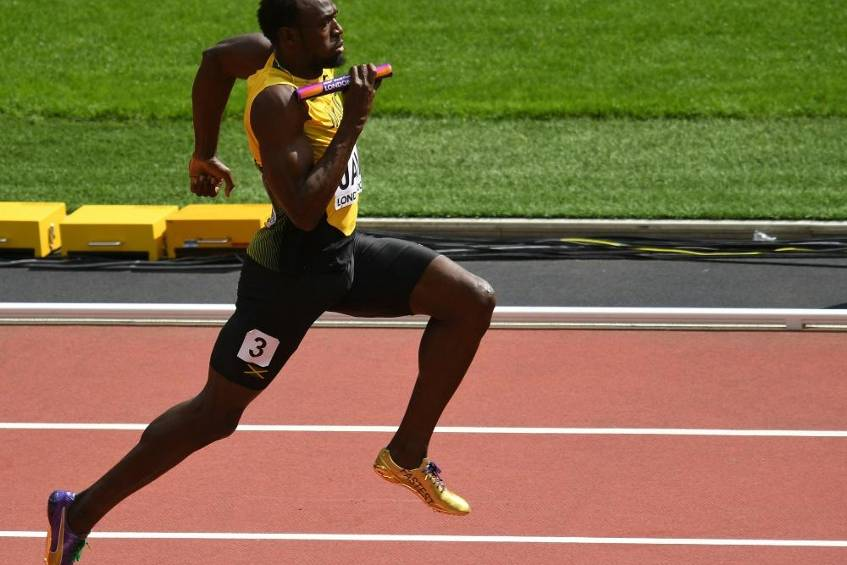

In [44]:
img_run

Walking
===

In [45]:
pred_walk,pred_idx,outputs = learn_new.predict(img_walk)
pred_walk

Category walking

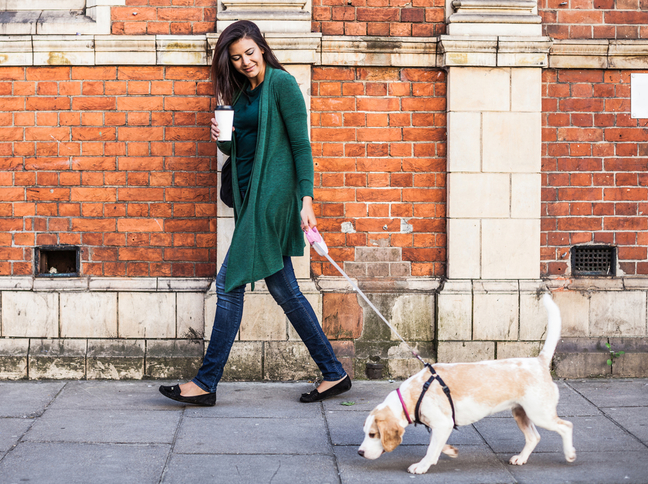

In [46]:
img_walk

Jumping
===

In [47]:
pred_jump,pred_idx,outputs = learn_new.predict(img_jump)
pred_jump

Category jumping

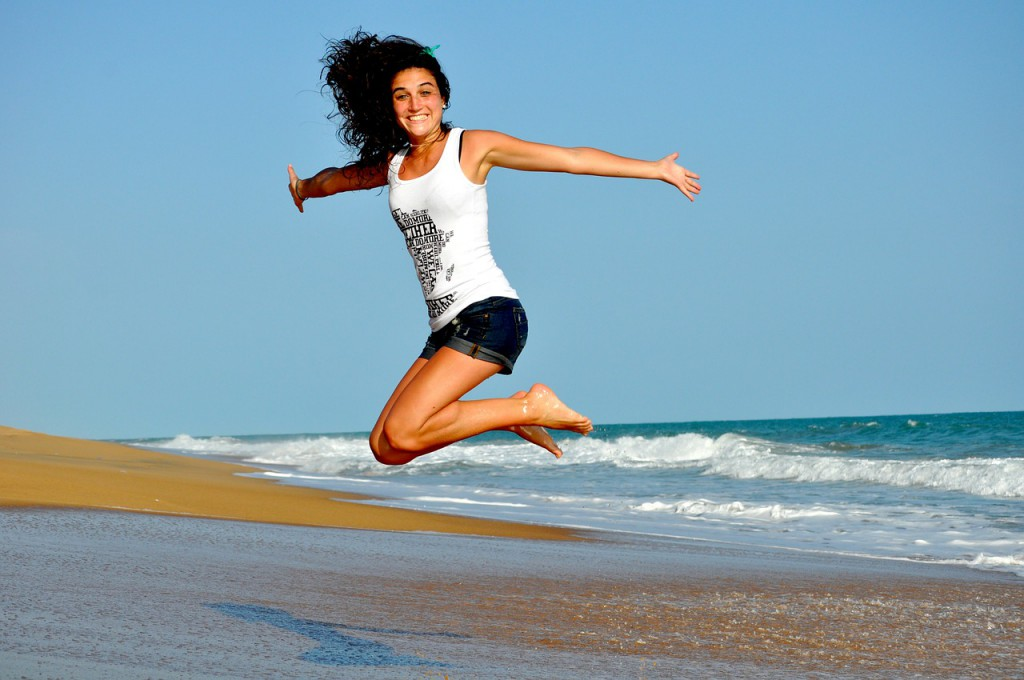

In [48]:
img_jump